**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-16 23:17:50--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
OpenSSL: error:0A000126:SSL routines::unexpected eof while reading
Unable to establish SSL connection.


In [3]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [4]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df['median_house_value'] = np.log(df['median_house_value'])

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.median_house_value)
y_val = (df_val.median_house_value)
y_test = (df_test.median_house_value)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.18,34.63,19.0,3562.0,606.0,1677.0,578.0,4.1573,INLAND
1,-116.90,34.69,10.0,337.0,102.0,108.0,50.0,0.4999,INLAND
2,-118.26,33.78,27.0,1672.0,491.0,1723.0,462.0,2.0458,NEAR OCEAN
3,-117.33,34.17,5.0,4718.0,1140.0,2564.0,1056.0,2.9877,INLAND
4,-119.02,35.35,42.0,1239.0,251.0,776.0,272.0,1.9830,INLAND


- We will use `DictVectorizer` to turn train and validation into matrices.

In [5]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
dicts_train = df_train.to_dict(orient='records')
dicts_val = df_val.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts_train)
X_val = dv.transform(dicts_val)

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [6]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [7]:
#@ INSPECTION:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/don/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


- Which feature is used for splitting the data?

- Answer: ocean_proximity=INLAND

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [8]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [9]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
round(rmse, 2)

0.25

<AxesSubplot: xlabel='median_house_value', ylabel='Count'>

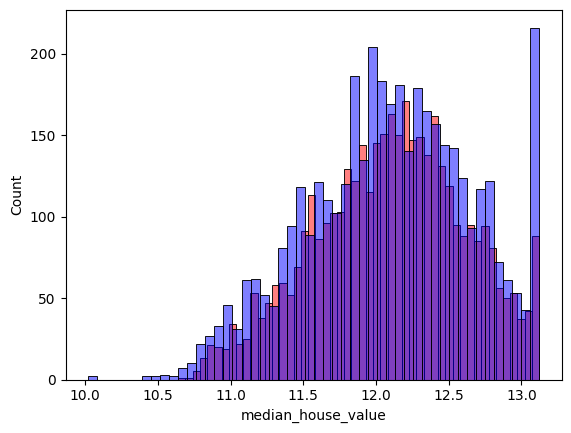

In [10]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

- What's the RMSE of this model on validation?

- Answer: 0.25

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [11]:
#@ TRAINING THE RANDOM FOREST MODEL:
rmse_scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append((n, rmse))

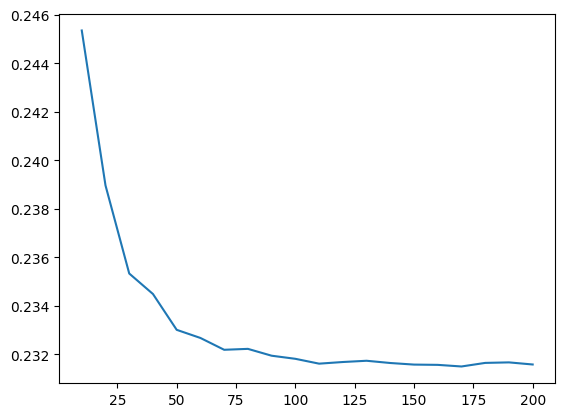

In [12]:
#@ INSPECTING THE RMSE SCORES:
columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(rmse_scores, columns=columns)
plt.plot(df_scores.n_estimators, df_scores.rmse)

- After which value of `n_estimators` does RMSE stop improving?

- Answer: 70

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [13]:
#@ TRAINING THE MODEL WITH DEPTH:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, random_state=1, max_depth=d, n_jobs=-1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((d, n, rmse))

In [20]:
columns = ['max_depth','n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,rmse
0,10,10,0.255491
1,10,20,0.253001
2,10,30,0.251680
3,10,40,0.251253
4,10,50,0.250249


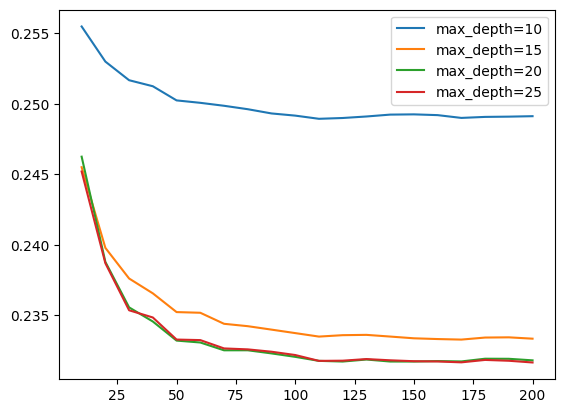

In [23]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)
    
plt.legend()

- What's the best `max_depth`:

- Answer: 25

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [24]:
#@ TRAINING THE RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=n, random_state=1, max_depth=20, n_jobs=-1)
rf.fit(X_train, y_train)
    
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse_scores.append((d, n, rmse))

In [37]:
df_importance = pd.DataFrame()
df_importance['feature'] = dv.get_feature_names()
df_importance['importance'] = rf.feature_importances_
df_importance.sort_values(by='importance', ascending=False)

/home/don/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
4,median_income,0.356341
6,ocean_proximity=INLAND,0.315544
2,latitude,0.100976
3,longitude,0.097191
1,housing_median_age,0.034091
10,population,0.030200
12,total_rooms,0.022026
11,total_bedrooms,0.018672
0,households,0.017651
9,ocean_proximity=NEAR OCEAN,0.004544


- What's the most important feature?

- Answer: median_income

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [39]:
import xgboost as xgb

In [40]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [41]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [48]:
xgb_params = {  
    'eta': 0.01,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [49]:
y_pred = model.predict(dval)

In [44]:
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred))
rmse_xgb

0.22783730798400148

In [47]:
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred))
rmse_xgb

0.23245311365589444

In [50]:
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred))
rmse_xgb

4.264994080718276

- Now, change eta first to 0.1 and then to 0.01.

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: 0.3